In [1]:
import os
import sys

try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, ".."))  
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
import scipy.sparse as sp
from utils_elicitation import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df, threshold_interactions_df_plus, train_test_split_csr

# !pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic_pair import Heuristic5
from pct.tree.heuristic.NumericHeuristic_pair import NumericHeuristic5
from pct.tree.splitter.splitter_yahoo import Splitter
from pct.tree.Yahootree import Tree

In [3]:
filtered_df = pd.read_csv("../Yahoodata/filtered_semi_binary.csv")
filtered_df

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,9,238709,0.00,artist,238709,0
1,9,169510,0.00,artist,169510,0
2,9,208084,1.00,artist,208084,0
3,9,245398,0.00,artist,245398,0
4,9,153166,0.00,artist,153166,0
...,...,...,...,...,...,...
1524889,248947,83754,0.01,artist,83754,0
1524890,248947,141799,0.00,genre,0,[141799]
1524891,248947,141677,0.00,artist,141677,0
1524892,248947,262458,0.00,artist,262458,0


In [4]:
# item type map
item_type_map = filtered_df.drop_duplicates(subset='item_id')[['item_id', 'item_type']]
item_type_map = dict(zip(item_type_map['item_id'], item_type_map['item_type']))

In [5]:
def get_item_type(item_id):
    return item_type_map.get(item_id, 'unknown')  


In [6]:
all_user_ids = sorted(filtered_df['user_id'].unique().tolist())

def split_users_by_ratio(all_user_ids, ratio):
    n = len(all_user_ids)
    split_point = int(n * ratio)
    warm_users = all_user_ids[:split_point]
    cold_users = all_user_ids[split_point:]
    return warm_users, cold_users

In [7]:
def split_and_combine(strategy="artist-only"):
    """Handles both approaches with proper matrix alignment"""
    # Get full cold matrix and mappings
    matrix_cold, rid_to_idx_cold, _, cid_to_idx, _ = df_to_matrix(
        df_cold, "user_id", "item_id", "rating"
    )
    matrix_cold = matrix_cold.tocsr()

    # Create boolean masks
    artist_mask = np.isin(
        np.arange(matrix_cold.shape[1]), 
        [cid_to_idx[iid] for iid in df_cold[df_cold['item_type'] == 'artist']['item_id']]
    )
    genre_mask = ~artist_mask

    # Create aligned matrices
    matrix_cold_artist = matrix_cold.multiply(artist_mask)
    matrix_cold_genre = matrix_cold.multiply(genre_mask)
    matrix_cold_artist = matrix_cold.multiply(artist_mask).tocsr()
    matrix_cold_genre = matrix_cold.multiply(genre_mask).tocsr()

    al_artist, test_cold, _ = train_test_split(
        matrix_cold_artist, 
        split_count=30,
        fraction=None
    )
    
    if strategy == "artist-only":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)  
        return K_cold, X_cold, test_cold
    
    elif strategy == "hybrid":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)
        X_cold = X_cold + matrix_cold_genre
        return K_cold, X_cold, test_cold

In [8]:
def data_builder(seed, warm_ratio=0.1, strategy="artist-only"):
    """
    说明：
    - fixed horiztonal split_users_by_ratio：warm/cold ）
    - randomness from K/X/T 的 np.random.choice（ np.random.seed(seed)）

    return：
    dict(
        train=K_cold, test=T_cold, X=X_cold, matrix_warm=matrix_warm,
        idx_to_rid_cold=idx_to_rid_cold, idx_to_rid_warm=idx_to_rid_warm, idx_to_cid=idx_to_cid,
        warm_users=warm_users_idx, cold_users=cold_users_idx
    )
    """
    import random
    import numpy as np

    # 1) Python random and NumPy random
    random.seed(seed)
    np.random.seed(seed)

    # 2) warm/cold split
    all_user_ids = sorted(filtered_df['user_id'].unique().tolist())
    warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, warm_ratio)

    # 3) global warm and cold dataframe
    global df_warm, df_cold
    df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
    df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

    # 4) matrix and mapping
    matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
        df_warm, "user_id", "item_id", "rating"
    )
    matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")

    # 5) K/X/T split (randomness)
    K_cold, X_cold, T_cold = split_and_combine(strategy)

    # 6) return
    return dict(
        train=K_cold, test=T_cold, X=X_cold, matrix_warm=matrix_warm,
        idx_to_rid_cold=idx_to_rid_cold, idx_to_rid_warm=idx_to_rid_warm, idx_to_cid=idx_to_cid,
        warm_users=warm_users_idx, cold_users=cold_users_idx
    )


In [9]:
# 1) two different seeds
out1 = data_builder(seed=7,  strategy="artist-only")
out2 = data_builder(seed=11, strategy="artist-only")

# 2) check warm/cold consistency（fixed aplit）
assert out1["warm_users"] == out2["warm_users"], "Warm split changed unexpectedly!"
assert out1["cold_users"] == out2["cold_users"], "Cold split changed unexpectedly!"

# 3) check if X / K / T change with seed set
#   check differnce in sparsity matrix
diff_X_nnz = (out1["X"] - out2["X"]).nnz
diff_K_nnz = (out1["train"] - out2["train"]).nnz
diff_T_nnz = (out1["test"] - out2["test"]).nnz
print("Δnnz(X)=", diff_X_nnz, "Δnnz(K)=", diff_K_nnz, "Δnnz(T)=", diff_T_nnz)

# 4) difference >0
assert (diff_X_nnz + diff_T_nnz) > 0, "K/X/T did not change across seeds as expected."


Δnnz(X)= 39948 Δnnz(K)= 1357 Δnnz(T)= 38739


In [10]:
def elicitation_by_pairwise_tree_retrain_skiped(
    Tree, train, test, X, matrix_warm,
    idx_to_rid_cold, idx_to_rid_warm, idx_to_cid,
    iteration=5, strategy=1,
    svd_random_state=None  # ← new parmeter：SVD random seed set
):
    """
    Pairwise tree-based elicitation (skip asked pairs). Retrain tree each round.
    At each iteration, select first unasked (itemA, itemB) pair and move both ratings from X to K.

    Parameters:
    - strategy: 1 (top2), 2 (most similar), 3 (least similar)

    Returns:
    - rmse_list, mae_list: performance metrics per iteration
    - item_type_stats: per-round asked item type counts
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    asked_pairs = {u: set() for u in range(num_users)}
    item_type_stats = defaultdict(lambda: defaultdict(int))
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(0, 1))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    # --- new：initialize SVD by random seed---
    algo = SVD(random_state=svd_random_state)
    # -------------------------------------------------
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    # Iterative elicitation
    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked pairs, walk from root)")
        # Step 1: Retrain tree
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i+1, min_instances=5, item_type_map=item_type_map)
        pct.fit(x_df, x_df, strategy=strategy)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root
            while node and not node.is_leaf and node.attribute_name:
                itemA, itemB = node.attribute_name
                if itemA not in cid_to_idx or itemB not in cid_to_idx:
                    node = None
                    break

                itemA_idx = cid_to_idx[itemA]
                itemB_idx = cid_to_idx[itemB]
                pair = frozenset([itemA_idx, itemB_idx])

                if pair in asked_pairs[u]:
                    ratingA = train_copy[u, itemA_idx]
                    ratingB = train_copy[u, itemB_idx]
                    if ratingA > ratingB:
                        node = node.children[0]
                    elif ratingB > ratingA:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked pair found
                ratingA = X_copy[u, itemA_idx]
                ratingB = X_copy[u, itemB_idx]

                if ratingA > 0:
                    train_copy[u, itemA_idx] = ratingA
                    X_copy[u, itemA_idx] = 0
                if ratingB > 0:
                    train_copy[u, itemB_idx] = ratingB
                    X_copy[u, itemB_idx] = 0

                asked_pairs[u].add(pair)

                # 🌟 Record item type (based on itemA)
                item_type = get_item_type(itemA)
                item_type_stats[i][item_type] += 1

                break  # only one pair per user per iteration

        # Step 2: Evaluate
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        # --- new：evauate SVD by same random seed---
        algo = SVD(random_state=svd_random_state)
        # -------------------------------------------------------------
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list, item_type_stats


In [11]:

def run_many_times_single_strategy(
    Tree,
    seeds,                 # e.g., [101,102,103,104,105]  -> R=5
    iteration=2,           # per time run iterations（keep baseline -> max curve lenghth=iteration+1）
    strategy=2,            # 1=top2, 2=most-similar, 3=least-similar
    mode="hybrid"          # hybrid
):
    """
    return:
      curves: np.ndarray, shape=(R, iteration+1)
              eveay row is a curve，including baseline
    """
    curves = []
    for sd in seeds:
        # 1) construct run data this iteration（K/X/T controled by seed）
        data = data_builder(seed=sd, strategy=mode)
        # 2)  elicitation（SVD by seed）
        rmse_list, _, _ = elicitation_by_pairwise_tree_retrain_skiped(
            Tree,
            data["train"], data["test"], data["X"], data["matrix_warm"],
            data["idx_to_rid_cold"], data["idx_to_rid_warm"], data["idx_to_cid"],
            iteration=iteration, strategy=strategy,
            svd_random_state=sd
        )
        curves.append(rmse_list)  # 长度 = iteration+1
    return np.stack(curves, axis=0)  # (R, iteration+1)


# —— average + min–max interval ——
def plot_mean_with_range_single(
    curves,                 # (R, T+1)，含 baseline
    title="Pairwise (single strategy)",
    label="Strategy"
):
    R, L = curves.shape
    T = L - 1  # iterations
    x = np.arange(0, L)  # from 0 baseline

    mean_curve = curves.mean(axis=0)
    lo = curves.min(axis=0)
    hi = curves.max(axis=0)

    plt.figure(figsize=(7,5))
    plt.plot(x, mean_curve, label=f"{label} (mean)")
    plt.fill_between(x, lo, hi, alpha=0.2, label="min–max range")
    plt.xticks(x, [f"{i}" for i in x])  # show 0,1,...,T；0 is baseline
    plt.xlabel("Iteration (0 = baseline)")
    plt.ylabel("RMSE")
    plt.title(f"{title} (R={R}) — Mean with min–max bands")
    plt.legend()
    plt.tight_layout()
    plt.show()


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5819
MAE:  0.4107
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5453
MAE:  0.4103
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 278591, 85921


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5327
MAE:  0.4126
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 212235


🔍 Pair found: 178617, 166141


🔍 Pair found: 13020, 183223


🔍 Pair found: 277719, 263587


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 31321, 203062


🔍 Pair found: 278591, 17037


🔍 Pair found: 190977, 83754


🔍 Pair found: 200632, 46776


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5295
MAE:  0.4117
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 257965


🔍 Pair found: 166141, 172223


🔍 Pair found: 211082, 175309


🔍 Pair found: 178617, 214565


🔍 Pair found: 187518, 19963


🔍 Pair found: 227957, 61547


🔍 Pair found: 166141, 226040


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 31321, 203062


🔍 Pair found: 196502, 204824


🔍 Pair found: 278591, 132285


🔍 Pair found: 17037, 281855


🔍 Pair found: 288449, 281855


🔍 Pair found: 113759, 90605


🔍 Pair found: 113759, 90605


🔍 Pair found: 187518, 212630


🔍 Pair found: 216799, 9890


🔍 Pair found: 15676, 279989


🔍 Pair found: 278591, 132285


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5251
MAE:  0.4107
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 189272


🔍 Pair found: 187696, 59956


🔍 Pair found: 59956, 220966


🔍 Pair found: 59956, 220966


🔍 Pair found: 277464, 52340


🔍 Pair found: 273176, 218424


🔍 Pair found: 270557, 161118


🔍 Pair found: 212235, 166141


🔍 Pair found: 211661, 276506


🔍 Pair found: 211661, 276506


🔍 Pair found: 172223, 166141


🔍 Pair found: 257965, 130043


🔍 Pair found: 257965, 258848


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 31321, 281022


🔍 Pair found: 214565, 35899


🔍 Pair found: 31321, 214565


🔍 Pair found: 18727, 89183


🔍 Pair found: 61316, 58658


🔍 Pair found: 278591, 83754


🔍 Pair found: 86954, 178617


🔍 Pair found: 280892, 57021


🔍 Pair found: 277464, 57021


🔍 Pair found: 288449, 113759


🔍 Pair found: 144732, 76575


🔍 Pair found: 76575, 144732


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5208
MAE:  0.4094
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 144802


🔍 Pair found: 166141, 172223


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 102299, 189015


🔍 Pair found: 195282, 11828


🔍 Pair found: 205381, 111982


🔍 Pair found: 166141, 257965


🔍 Pair found: 172223, 166141


🔍 Pair found: 105146, 214565


🔍 Pair found: 189272, 281785


🔍 Pair found: 106761, 238709


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 189272, 57021


🔍 Pair found: 257965, 189272


🔍 Pair found: 257965, 189272


🔍 Pair found: 257965, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 31321, 281022


🔍 Pair found: 214565, 35899


🔍 Pair found: 281855, 15676


🔍 Pair found: 281022, 257019


🔍 Pair found: 281022, 151848


🔍 Pair found: 18727, 89183


🔍 Pair found: 61316, 58658


🔍 Pair found: 18727, 89183


🔍 Pair found: 278591, 183223


🔍 Pair found: 110768, 136993


🔍 Pair found: 54975, 647


🔍 Pair found: 54975, 647


🔍 Pair found: 54975, 647


🔍 Pair found: 127151, 57021


🔍 Pair found: 57021, 127151


🔍 Pair found: 57021, 127151


🔍 Pair found: 57021, 127151


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5193
MAE:  0.4100
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 144732


🔍 Pair found: 172223, 166141


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 26283, 37604


🔍 Pair found: 119186, 88548


🔍 Pair found: 263587, 103916


🔍 Pair found: 209791, 26283


🔍 Pair found: 33269, 144732


🔍 Pair found: 68667, 114043


🔍 Pair found: 191351, 276506


🔍 Pair found: 276506, 191351


🔍 Pair found: 276506, 191351


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 31321, 281022


🔍 Pair found: 214565, 35899


🔍 Pair found: 15676, 281855


🔍 Pair found: 281022, 15676


🔍 Pair found: 214565, 281022


🔍 Pair found: 214565, 281022


🔍 Pair found: 18727, 204824


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 58658


🔍 Pair found: 183223, 75017


🔍 Pair found: 75017, 183223


🔍 Pair found: 278591, 230232


🔍 Pair found: 205381, 210727


🔍 Pair found: 280892, 257658


🔍 Pair found: 190518, 17037


🔍 Pair found: 190518, 17037


🔍 Pair found: 190518, 17037


🔍 Pair found: 215527, 76575


🔍 Pair found: 206388, 212630


🔍 Pair found: 251690, 195412


🔍 Pair found: 186392, 252460


🔍 Pair found: 252460, 186392


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5082
MAE:  0.4093
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 85921


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 199204, 293119


🔍 Pair found: 149019, 66676


🔍 Pair found: 14491, 124134


🔍 Pair found: 166141, 257965


🔍 Pair found: 172223, 166141


🔍 Pair found: 144732, 105146


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 189272, 281785


🔍 Pair found: 106761, 238709


🔍 Pair found: 212235, 144802


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 89183, 168967


🔍 Pair found: 51223, 238709


🔍 Pair found: 18727, 247758


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 257965


🔍 Pair found: 180964, 76503


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 291792


🔍 Pair found: 3091, 291792


🔍 Pair found: 3091, 291792


🔍 Pair found: 3091, 291792


🔍 Pair found: 3091, 291792


🔍 Pair found: 278591, 232439


🔍 Pair found: 256310, 28341


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5048
MAE:  0.4091
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 112400


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 83754, 103916


🔍 Pair found: 166141, 257965


🔍 Pair found: 172223, 166141


🔍 Pair found: 144732, 105146


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 85921, 35127


🔍 Pair found: 85921, 189272


🔍 Pair found: 144802, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 85921, 257965


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 89183, 168967


🔍 Pair found: 281022, 18727


🔍 Pair found: 51223, 238709


🔍 Pair found: 247758, 281022


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 257965


🔍 Pair found: 180964, 76503


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 278424


🔍 Pair found: 76575, 132285


🔍 Pair found: 3091, 214565


🔍 Pair found: 62346, 248969


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 3091


🔍 Pair found: 214565, 3091


🔍 Pair found: 214565, 3091


🔍 Pair found: 289463, 278424


🔍 Pair found: 291792, 278424


🔍 Pair found: 278424, 191898


🔍 Pair found: 278424, 191898


🔍 Pair found: 278424, 191898


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 151848


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 2488, 222273


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5019
MAE:  0.4067
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 172223, 166141


🔍 Pair found: 178617, 189272


🔍 Pair found: 218424, 281022


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 89183


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 18727


🔍 Pair found: 51223, 238709


🔍 Pair found: 89183, 238709


🔍 Pair found: 247758, 281022


🔍 Pair found: 238709, 169510


🔍 Pair found: 257965, 279967


🔍 Pair found: 257965, 161583


🔍 Pair found: 257965, 161583


🔍 Pair found: 257965, 161583


🔍 Pair found: 257965, 161583


🔍 Pair found: 257965, 161583


🔍 Pair found: 172223, 31321


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 153166


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 151848


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 288449, 202309


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5003
MAE:  0.4063
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 218424, 281022


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 18727


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 31321


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 257965


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 257965, 10859


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 149094


🔍 Pair found: 51948, 153166


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 202309, 252460


🔍 Pair found: 230232, 202309


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5013
MAE:  0.4073
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 218424, 281022


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 18727


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 31321


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 257965


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 257965, 10859


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 51948, 257965


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 202309, 252460


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5012
MAE:  0.4076
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 18727


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 31321


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 257965


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 10859, 257965


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 257965, 153166


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 202309, 252460


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5012
MAE:  0.4076
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 18727


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 31321


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 257965


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 10859, 257965


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 257965, 153166


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 202309, 252460


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5003
MAE:  0.4074
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 18727


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 31321


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 257965


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 10859, 257965


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 257965, 153166


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 154230


🔍 Pair found: 230232, 211082


🔍 Pair found: 202309, 252460


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5003
MAE:  0.4074
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 18727


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 31321


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 257965


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 10859, 257965


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 257965, 153166


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 154230


🔍 Pair found: 230232, 91211


🔍 Pair found: 202309, 252460


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5003
MAE:  0.4074
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 18727


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 31321


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 257965


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 10859, 257965


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 257965, 153166


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 154230


🔍 Pair found: 230232, 91211


🔍 Pair found: 202309, 252460


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5003
MAE:  0.4074
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 18727


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 31321


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 257965


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 10859, 257965


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 257965, 153166


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 154230


🔍 Pair found: 230232, 91211


🔍 Pair found: 202309, 252460


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5003
MAE:  0.4074
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 18727


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 31321


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 257965


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 10859, 257965


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 257965, 153166


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 154230


🔍 Pair found: 230232, 91211


🔍 Pair found: 202309, 252460


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5003
MAE:  0.4074
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 191898, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 214565


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 18727


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 281022, 31321


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 168967, 117235


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 257965


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 279967, 172223


🔍 Pair found: 10859, 257965


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 257965, 10859


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 18727, 214565


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 214565, 18727


🔍 Pair found: 3091, 204824


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 180868, 132285


🔍 Pair found: 257965, 153166


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 204824, 18727


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 154230


🔍 Pair found: 230232, 91211


🔍 Pair found: 202309, 252460


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5003
MAE:  0.4074
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5833
MAE:  0.4100
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5478
MAE:  0.4109
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 278591, 85921


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5345
MAE:  0.4116
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 212235


🔍 Pair found: 178617, 166141


🔍 Pair found: 13020, 183223


🔍 Pair found: 277719, 263587


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 31321, 203062


🔍 Pair found: 278591, 17037


🔍 Pair found: 190977, 83754


🔍 Pair found: 200632, 46776


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5315
MAE:  0.4110
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 257965


🔍 Pair found: 166141, 172223


🔍 Pair found: 211082, 175309


🔍 Pair found: 178617, 257965


🔍 Pair found: 187518, 19963


🔍 Pair found: 227957, 61547


🔍 Pair found: 166141, 226040


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 31321, 203062


🔍 Pair found: 196502, 177488


🔍 Pair found: 278591, 132285


🔍 Pair found: 17037, 281855


🔍 Pair found: 288449, 281855


🔍 Pair found: 113759, 90605


🔍 Pair found: 113759, 90605


🔍 Pair found: 189015, 202309


🔍 Pair found: 113759, 252460


🔍 Pair found: 70850, 131753


🔍 Pair found: 278591, 132285


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5288
MAE:  0.4111
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 189272


🔍 Pair found: 59956, 220966


🔍 Pair found: 59956, 220966


🔍 Pair found: 59956, 220966


🔍 Pair found: 277464, 52340


🔍 Pair found: 273176, 218424


🔍 Pair found: 270557, 161118


🔍 Pair found: 212235, 166141


🔍 Pair found: 211661, 276506


🔍 Pair found: 211661, 276506


🔍 Pair found: 172223, 166141


🔍 Pair found: 257965, 207587


🔍 Pair found: 257965, 131340


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 31321, 180964


🔍 Pair found: 190518, 232439


🔍 Pair found: 190518, 232439


🔍 Pair found: 62335, 277464


🔍 Pair found: 217654, 91211


🔍 Pair found: 278591, 83754


🔍 Pair found: 277464, 164214


🔍 Pair found: 57021, 195282


🔍 Pair found: 57021, 277464


🔍 Pair found: 288449, 113759


🔍 Pair found: 144732, 76575


🔍 Pair found: 76575, 144732


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5206
MAE:  0.4085
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 144802


🔍 Pair found: 166141, 172223


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 102299, 189015


🔍 Pair found: 195282, 11828


🔍 Pair found: 205381, 111982


🔍 Pair found: 62616, 68667


🔍 Pair found: 166141, 61547


🔍 Pair found: 172223, 166141


🔍 Pair found: 257965, 189272


🔍 Pair found: 257965, 189272


🔍 Pair found: 166141, 172223


🔍 Pair found: 277719, 113344


🔍 Pair found: 277719, 113344


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 245398, 153166


🔍 Pair found: 245398, 153166


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 204824, 196502


🔍 Pair found: 204824, 196502


🔍 Pair found: 204824, 196502


🔍 Pair found: 278591, 183223


🔍 Pair found: 110768, 136993


🔍 Pair found: 54975, 647


🔍 Pair found: 54975, 647


🔍 Pair found: 54975, 647


🔍 Pair found: 127151, 57021


🔍 Pair found: 57021, 127151


🔍 Pair found: 57021, 127151


🔍 Pair found: 57021, 127151


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5197
MAE:  0.4091
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 144732


🔍 Pair found: 172223, 166141


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 26283, 37604


🔍 Pair found: 119186, 88548


🔍 Pair found: 263587, 103916


🔍 Pair found: 209791, 26283


🔍 Pair found: 33269, 144732


🔍 Pair found: 68667, 114043


🔍 Pair found: 191351, 276506


🔍 Pair found: 276506, 191351


🔍 Pair found: 276506, 191351


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 245398, 153166


🔍 Pair found: 245398, 153166


🔍 Pair found: 245398, 153166


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 196502


🔍 Pair found: 31321, 203062


🔍 Pair found: 31321, 214565


🔍 Pair found: 247758, 204824


🔍 Pair found: 31321, 203062


🔍 Pair found: 278591, 230232


🔍 Pair found: 205381, 210727


🔍 Pair found: 280892, 57021


🔍 Pair found: 57021, 280892


🔍 Pair found: 57021, 280892


🔍 Pair found: 57021, 280892


🔍 Pair found: 215527, 76575


🔍 Pair found: 206388, 212630


🔍 Pair found: 251690, 195412


🔍 Pair found: 186392, 252460


🔍 Pair found: 252460, 186392


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5116
MAE:  0.4086
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 85921


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 199204, 293119


🔍 Pair found: 149019, 66676


🔍 Pair found: 14491, 124134


🔍 Pair found: 166141, 257965


🔍 Pair found: 172223, 166141


🔍 Pair found: 144732, 243550


🔍 Pair found: 66206, 212235


🔍 Pair found: 279967, 189272


🔍 Pair found: 279967, 189272


🔍 Pair found: 279967, 189272


🔍 Pair found: 144802, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 245398, 153166


🔍 Pair found: 245398, 153166


🔍 Pair found: 245398, 153166


🔍 Pair found: 245398, 153166


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 196502, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 177488


🔍 Pair found: 253660, 230232


🔍 Pair found: 253660, 230232


🔍 Pair found: 253660, 230232


🔍 Pair found: 278591, 232439


🔍 Pair found: 256310, 28341


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5082
MAE:  0.4079
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 112400


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 83754, 103916


🔍 Pair found: 166141, 257965


🔍 Pair found: 172223, 166141


🔍 Pair found: 144732, 243550


🔍 Pair found: 66206, 212235


🔍 Pair found: 85921, 279967


🔍 Pair found: 85921, 279967


🔍 Pair found: 85921, 279967


🔍 Pair found: 85921, 279967


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 85921, 257965


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 153166, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 196502, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 177488


🔍 Pair found: 253660, 230232


🔍 Pair found: 253660, 230232


🔍 Pair found: 253660, 230232


🔍 Pair found: 253660, 230232


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 151848


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 2488, 222273


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5048
MAE:  0.4065
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 144732, 5232


🔍 Pair found: 178617, 172223


🔍 Pair found: 172223, 178617


🔍 Pair found: 172223, 178617


🔍 Pair found: 172223, 178617


🔍 Pair found: 172223, 178617


🔍 Pair found: 172223, 178617


🔍 Pair found: 178617, 189272


🔍 Pair found: 218424, 281022


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 245398


🔍 Pair found: 257965, 245398


🔍 Pair found: 257965, 245398


🔍 Pair found: 257965, 245398


🔍 Pair found: 257965, 245398


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 258210


🔍 Pair found: 166141, 258210


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 1116, 124282


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 22521, 180964


🔍 Pair found: 166141, 115386


🔍 Pair found: 166141, 115386


🔍 Pair found: 166141, 115386


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 196502, 209791


🔍 Pair found: 214565, 196502


🔍 Pair found: 214565, 196502


🔍 Pair found: 214565, 196502


🔍 Pair found: 214565, 196502


🔍 Pair found: 214565, 278591


🔍 Pair found: 214565, 31321


🔍 Pair found: 214565, 177488


🔍 Pair found: 214565, 172223


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 151848


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 288449, 210805


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5043
MAE:  0.4070
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 218424, 281022


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 48525, 257965


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 245398, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 258210


🔍 Pair found: 166141, 258210


🔍 Pair found: 166141, 258210


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 1116, 124282


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 22521, 180964


🔍 Pair found: 166141, 115386


🔍 Pair found: 166141, 115386


🔍 Pair found: 166141, 115386


🔍 Pair found: 166141, 115386


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 196502, 133723


🔍 Pair found: 214565, 196502


🔍 Pair found: 214565, 196502


🔍 Pair found: 214565, 196502


🔍 Pair found: 214565, 196502


🔍 Pair found: 214565, 196502


🔍 Pair found: 247758, 209791


🔍 Pair found: 214565, 278591


🔍 Pair found: 214565, 31321


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 202309


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5033
MAE:  0.4062
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 218424, 141075


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 48525, 257965


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 245398, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 258210


🔍 Pair found: 166141, 258210


🔍 Pair found: 166141, 258210


🔍 Pair found: 166141, 258210


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 124282, 1116


🔍 Pair found: 124282, 231560


🔍 Pair found: 1116, 124282


🔍 Pair found: 1116, 124282


🔍 Pair found: 1116, 124282


🔍 Pair found: 1116, 124282


🔍 Pair found: 1116, 124282


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 211082, 202309


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5024
MAE:  0.4057
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 17678


🔍 Pair found: 149094, 161583


🔍 Pair found: 61547, 172223


🔍 Pair found: 166141, 85921


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 48525, 257965


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 245398, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 124282, 231560


🔍 Pair found: 218063, 238709


🔍 Pair found: 196502, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 252460, 154230


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5025
MAE:  0.4060
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 48525, 257965


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 245398, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 124282, 231560


🔍 Pair found: 218063, 124282


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 91211


🔍 Pair found: 252460, 91211


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5015
MAE:  0.4060
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 48525, 257965


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 245398, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 124282, 231560


🔍 Pair found: 218063, 124282


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 232439, 91211


🔍 Pair found: 230232, 232439


🔍 Pair found: 252460, 202309


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5018
MAE:  0.4060
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 48525, 257965


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 245398, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 124282, 231560


🔍 Pair found: 218063, 124282


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 91211, 85522


🔍 Pair found: 230232, 211082


🔍 Pair found: 232439, 211082


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5018
MAE:  0.4060
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 48525, 257965


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 245398, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 124282, 231560


🔍 Pair found: 218063, 124282


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 91211, 85522


🔍 Pair found: 230232, 211082


🔍 Pair found: 232439, 211082


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5018
MAE:  0.4060
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 48525, 257965


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 245398, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 124282, 231560


🔍 Pair found: 218063, 124282


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 91211, 85522


🔍 Pair found: 230232, 211082


🔍 Pair found: 232439, 211082


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5018
MAE:  0.4060
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 48525, 257965


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 245398, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 124282, 231560


🔍 Pair found: 218063, 124282


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 91211, 85522


🔍 Pair found: 230232, 211082


🔍 Pair found: 232439, 211082


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5018
MAE:  0.4060
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 278424


🔍 Pair found: 189015, 252460


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 183223, 189015


🔍 Pair found: 191898, 214565


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 189015, 183223


🔍 Pair found: 214565, 278424


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 278424, 214565


🔍 Pair found: 180964, 257353


🔍 Pair found: 180964, 214565


🔍 Pair found: 238709, 250987


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 48525, 257965


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 48525, 172223


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 257965, 48525


🔍 Pair found: 245398, 257965


🔍 Pair found: 172223, 238709


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 153166, 67436


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 214565, 180964


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 202309, 47482


🔍 Pair found: 204824, 31321


🔍 Pair found: 166141, 115386


🔍 Pair found: 214565, 204824


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 203494


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 166141, 31321


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 214565, 204824


🔍 Pair found: 124282, 231560


🔍 Pair found: 218063, 124282


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 22521, 180964


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 204824, 214565


🔍 Pair found: 284068, 187609


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 214565


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 133723, 196502


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 91211, 85522


🔍 Pair found: 230232, 211082


🔍 Pair found: 232439, 211082


🔍 Pair found: 288449, 154230


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5018
MAE:  0.4060
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5799
MAE:  0.4091
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5635
MAE:  0.4116
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 170825, 232439


🔍 Pair found: 102299, 3091


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5601
MAE:  0.4112
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 232439, 170825


🔍 Pair found: 172223, 232439


🔍 Pair found: 170825, 79867


🔍 Pair found: 76575, 237418


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 203553


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5535
MAE:  0.4106
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 170825


🔍 Pair found: 172223, 232439


🔍 Pair found: 170825, 79867


🔍 Pair found: 237418, 273577


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 203553


🔍 Pair found: 70850, 85921


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5482
MAE:  0.4108
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 169510


🔍 Pair found: 232439, 87722


🔍 Pair found: 232439, 85768


🔍 Pair found: 238709, 169510


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 131753, 172223


🔍 Pair found: 170825, 265177


🔍 Pair found: 31321, 79867


🔍 Pair found: 172223, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 195282


🔍 Pair found: 3091, 195282


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5482
MAE:  0.4115
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 232439, 87722


🔍 Pair found: 232439, 85768


🔍 Pair found: 232439, 130932


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 232439, 31321


🔍 Pair found: 144802, 281785


🔍 Pair found: 172223, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 195282


🔍 Pair found: 3091, 195282


🔍 Pair found: 3091, 195282


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5465
MAE:  0.4107
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 152062, 21644


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 232439, 31321


🔍 Pair found: 144802, 281785


🔍 Pair found: 172223, 131753


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 172223, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5450
MAE:  0.4105
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 165176, 238709


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5449
MAE:  0.4106
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 99775


🔍 Pair found: 21644, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5449
MAE:  0.4106
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 99775


🔍 Pair found: 21644, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5450
MAE:  0.4107
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 238709


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5450
MAE:  0.4107
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 238709


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5453
MAE:  0.4107
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 238709


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 169510, 245398


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5451
MAE:  0.4105
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 238709


🔍 Pair found: 169510, 245398


🔍 Pair found: 152062, 21644


🔍 Pair found: 99775, 87722


🔍 Pair found: 99775, 87722


🔍 Pair found: 99775, 87722


🔍 Pair found: 99775, 87722


🔍 Pair found: 99775, 87722


🔍 Pair found: 99775, 87722


🔍 Pair found: 99775, 87722


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5451
MAE:  0.4105
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 238709


🔍 Pair found: 169510, 245398


🔍 Pair found: 152062, 99775


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5451
MAE:  0.4105
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 238709


🔍 Pair found: 169510, 245398


🔍 Pair found: 152062, 99775


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5451
MAE:  0.4105
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 238709


🔍 Pair found: 169510, 245398


🔍 Pair found: 152062, 99775


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5451
MAE:  0.4105
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 238709


🔍 Pair found: 169510, 245398


🔍 Pair found: 152062, 99775


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5451
MAE:  0.4105
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 238709


🔍 Pair found: 169510, 245398


🔍 Pair found: 152062, 99775


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5451
MAE:  0.4105
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 144802


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 172223


🔍 Pair found: 232439, 232604


🔍 Pair found: 238709, 165176


🔍 Pair found: 131753, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 232439


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 87722, 99775


🔍 Pair found: 232439, 238709


🔍 Pair found: 169510, 245398


🔍 Pair found: 152062, 99775


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 76575, 172223


🔍 Pair found: 172223, 51948


🔍 Pair found: 281785, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 172223, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 281785, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 76575, 131753


🔍 Pair found: 102299, 161019


🔍 Pair found: 277464, 196502


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 3091, 70850


🔍 Pair found: 165176, 286886


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 102299, 161019


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


🔍 Pair found: 172223, 144802


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5451
MAE:  0.4105
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5823
MAE:  0.4116
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5458
MAE:  0.4113
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 278591, 85921


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5328
MAE:  0.4119
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 212235


🔍 Pair found: 178617, 166141


🔍 Pair found: 13020, 183223


🔍 Pair found: 277719, 263587


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 289463


🔍 Pair found: 278591, 17037


🔍 Pair found: 190977, 83754


🔍 Pair found: 200632, 46776


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5293
MAE:  0.4104
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 257965


🔍 Pair found: 166141, 172223


🔍 Pair found: 178617, 257965


🔍 Pair found: 187518, 19963


🔍 Pair found: 227957, 61547


🔍 Pair found: 166141, 226040


🔍 Pair found: 191898, 247758


🔍 Pair found: 79867, 51948


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 238709, 169510


🔍 Pair found: 291792, 178205


🔍 Pair found: 214565, 291792


🔍 Pair found: 142360, 244384


🔍 Pair found: 3091, 253660


🔍 Pair found: 278591, 132285


🔍 Pair found: 17037, 281855


🔍 Pair found: 288449, 281855


🔍 Pair found: 113759, 90605


🔍 Pair found: 113759, 90605


🔍 Pair found: 189015, 202309


🔍 Pair found: 113759, 252460


🔍 Pair found: 70850, 131753


🔍 Pair found: 278591, 132285


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5236
MAE:  0.4093
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 189272


🔍 Pair found: 190518, 35911


🔍 Pair found: 190518, 35911


🔍 Pair found: 190518, 35911


🔍 Pair found: 277464, 52340


🔍 Pair found: 273176, 218424


🔍 Pair found: 270557, 161118


🔍 Pair found: 212235, 166141


🔍 Pair found: 85921, 211661


🔍 Pair found: 166141, 23301


🔍 Pair found: 172223, 166141


🔍 Pair found: 257965, 185759


🔍 Pair found: 257965, 141604


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 212235


🔍 Pair found: 166141, 212235


🔍 Pair found: 191898, 247758


🔍 Pair found: 79867, 51948


🔍 Pair found: 260371, 214565


[⚠️] No same-type candidates for itemA=126500, returning None.
🔍 Pair found: None, None


🔍 Pair found: 214565, 191898


🔍 Pair found: 172223, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 178205, 56111


🔍 Pair found: 178205, 214565


🔍 Pair found: 7855, 49866


🔍 Pair found: 278591, 83754


🔍 Pair found: 86954, 178617


🔍 Pair found: 280892, 57021


🔍 Pair found: 277464, 57021


🔍 Pair found: 288449, 113759


🔍 Pair found: 144732, 76575


🔍 Pair found: 76575, 144732


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5197
MAE:  0.4087
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 144802


🔍 Pair found: 257965, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 178617, 189272


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 102299, 189015


🔍 Pair found: 195282, 11828


🔍 Pair found: 205381, 111982


🔍 Pair found: 166141, 257965


🔍 Pair found: 172223, 166141


🔍 Pair found: 253718, 212235


🔍 Pair found: 189272, 222730


🔍 Pair found: 212235, 257965


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 189272, 57021


🔍 Pair found: 257965, 189272


🔍 Pair found: 257965, 212235


🔍 Pair found: 257965, 214565


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 79867, 51948


🔍 Pair found: 214565, 191898


[⚠️] No same-type candidates for itemA=126500, returning None.
🔍 Pair found: None, None


🔍 Pair found: 214565, 191898


🔍 Pair found: 172223, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279513, 178205


🔍 Pair found: 246953, 229946


🔍 Pair found: 214565, 291792


🔍 Pair found: 189272, 136574


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 178205, 56111


🔍 Pair found: 178205, 214565


🔍 Pair found: 257965, 31321


🔍 Pair found: 247758, 191898


🔍 Pair found: 214565, 178205


🔍 Pair found: 7855, 49866


🔍 Pair found: 118736, 277464


🔍 Pair found: 278591, 183223


🔍 Pair found: 110768, 136993


🔍 Pair found: 54975, 280892


🔍 Pair found: 54975, 280892


🔍 Pair found: 54975, 280892


🔍 Pair found: 127151, 57021


🔍 Pair found: 57021, 127151


🔍 Pair found: 57021, 127151


🔍 Pair found: 57021, 127151


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5180
MAE:  0.4084
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 144732


🔍 Pair found: 172223, 257965


🔍 Pair found: 178617, 172223


🔍 Pair found: 172223, 178617


🔍 Pair found: 172223, 178617


🔍 Pair found: 172223, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 26283, 37604


🔍 Pair found: 119186, 88548


🔍 Pair found: 263587, 103916


🔍 Pair found: 209791, 26283


🔍 Pair found: 33269, 144732


🔍 Pair found: 68667, 114043


🔍 Pair found: 191351, 276506


🔍 Pair found: 276506, 191351


🔍 Pair found: 276506, 191351


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 238709, 140537


🔍 Pair found: 172223, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279513, 178205


🔍 Pair found: 246953, 229946


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 230232


🔍 Pair found: 205381, 210727


🔍 Pair found: 280892, 57021


🔍 Pair found: 57021, 280892


🔍 Pair found: 57021, 280892


🔍 Pair found: 57021, 280892


🔍 Pair found: 215527, 76575


🔍 Pair found: 206388, 212630


🔍 Pair found: 251690, 195412


🔍 Pair found: 186392, 252460


🔍 Pair found: 252460, 186392


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5126
MAE:  0.4093
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 85921


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 225171, 292756


🔍 Pair found: 199204, 293119


🔍 Pair found: 149019, 66676


🔍 Pair found: 14491, 124134


🔍 Pair found: 166141, 257965


🔍 Pair found: 172223, 166141


🔍 Pair found: 144732, 253718


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 189272, 222730


🔍 Pair found: 212235, 144802


🔍 Pair found: 238709, 169510


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 189272, 257965


🔍 Pair found: 257965, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 257965, 189272


🔍 Pair found: 257965, 189272


🔍 Pair found: 257965, 189272


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 172223


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 188084


🔍 Pair found: 140537, 188084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279513, 178205


🔍 Pair found: 246953, 229946


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 232439


🔍 Pair found: 256310, 28341


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5086
MAE:  0.4074
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 112400


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 209104, 208467


🔍 Pair found: 83754, 103916


🔍 Pair found: 166141, 257965


🔍 Pair found: 172223, 166141


🔍 Pair found: 144732, 253718


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 85921, 144732


🔍 Pair found: 85921, 189272


🔍 Pair found: 144802, 238709


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 85921, 257965


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 172223


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 188084


🔍 Pair found: 140537, 188084


🔍 Pair found: 140537, 188084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 151848


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 2488, 222273


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5079
MAE:  0.4080
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 270238, 285087


🔍 Pair found: 285087, 270238


🔍 Pair found: 285087, 270238


🔍 Pair found: 285087, 270238


🔍 Pair found: 285087, 270238


🔍 Pair found: 285087, 270238


🔍 Pair found: 285087, 270238


🔍 Pair found: 285087, 270238


🔍 Pair found: 144802, 83754


🔍 Pair found: 72371, 189015


🔍 Pair found: 189272, 214565


🔍 Pair found: 144802, 172223


🔍 Pair found: 34602, 151565


🔍 Pair found: 294545, 113759


🔍 Pair found: 54289, 11731


🔍 Pair found: 54289, 11731


🔍 Pair found: 54289, 11731


🔍 Pair found: 54289, 11731


🔍 Pair found: 54289, 11731


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 151848


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 288449, 202309


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5071
MAE:  0.4070
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 112400, 149019


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 244384, 210805


🔍 Pair found: 191898, 210805


🔍 Pair found: 66676, 151565


🔍 Pair found: 196502, 52340


🔍 Pair found: 263882, 51633


🔍 Pair found: 263882, 51633


🔍 Pair found: 263882, 51633


🔍 Pair found: 263882, 51633


🔍 Pair found: 263882, 51633


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 211082, 202309


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5030
MAE:  0.4076
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 172313, 173467


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 112400, 149019


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 210805, 166141


🔍 Pair found: 172223, 210805


🔍 Pair found: 85921, 166141


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 285743, 31321


🔍 Pair found: 172223, 210805


🔍 Pair found: 257965, 172223


🔍 Pair found: 172223, 166141


🔍 Pair found: 189272, 214565


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 189272, 85921


🔍 Pair found: 257965, 244384


🔍 Pair found: 51596, 212235


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5030
MAE:  0.4075
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 172313, 173467


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 112400, 149019


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 210805, 166141


🔍 Pair found: 172223, 210805


🔍 Pair found: 85921, 166141


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 285743, 31321


🔍 Pair found: 172223, 210805


🔍 Pair found: 257965, 172223


🔍 Pair found: 172223, 166141


🔍 Pair found: 189272, 214565


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 172223


🔍 Pair found: 189272, 85921


🔍 Pair found: 257965, 244384


🔍 Pair found: 51596, 212235


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5039
MAE:  0.4090
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 172313, 173467


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 112400, 149019


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 210805, 166141


🔍 Pair found: 172223, 210805


🔍 Pair found: 85921, 166141


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 212235, 180964


🔍 Pair found: 285743, 180964


🔍 Pair found: 172223, 210805


🔍 Pair found: 257965, 172223


🔍 Pair found: 172223, 166141


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 85921, 257965


🔍 Pair found: 189272, 85921


🔍 Pair found: 257965, 193954


🔍 Pair found: 257965, 193954


🔍 Pair found: 257965, 193954


🔍 Pair found: 257965, 193954


🔍 Pair found: 257965, 193954


🔍 Pair found: 257965, 193954


🔍 Pair found: 257965, 193954


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5036
MAE:  0.4082
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 172313, 173467


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 112400, 149019


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 210805, 166141


🔍 Pair found: 172223, 210805


🔍 Pair found: 85921, 166141


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 180964, 257965


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 85921, 144732


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5036
MAE:  0.4082
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 172313, 173467


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 112400, 149019


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 210805, 166141


🔍 Pair found: 172223, 210805


🔍 Pair found: 85921, 166141


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 180964, 257965


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 85921, 144732


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5036
MAE:  0.4082
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 172313, 173467


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 112400, 149019


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 210805, 166141


🔍 Pair found: 172223, 210805


🔍 Pair found: 85921, 166141


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 180964, 257965


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 85921, 144732


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5036
MAE:  0.4082
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 172313, 173467


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 112400, 149019


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 210805, 166141


🔍 Pair found: 172223, 210805


🔍 Pair found: 85921, 166141


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 180964, 257965


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 85921, 144732


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5036
MAE:  0.4082
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 172313, 173467


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 112400, 149019


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 210805, 166141


🔍 Pair found: 172223, 210805


🔍 Pair found: 85921, 166141


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 180964, 257965


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 85921, 144732


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5036
MAE:  0.4082
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 277719


🔍 Pair found: 172313, 173467


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 173467, 172313


🔍 Pair found: 112400, 149019


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 149019, 112400


🔍 Pair found: 210805, 166141


🔍 Pair found: 172223, 210805


🔍 Pair found: 85921, 166141


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 166141, 85921


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 210805, 172223


🔍 Pair found: 180964, 257965


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 180964, 172223


🔍 Pair found: 85921, 144732


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 144732, 85921


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 257965, 180964


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 210805, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 79867


🔍 Pair found: 214565, 191898


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 172223


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 110541, 140537


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 140537, 110541


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 79867, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 208084, 238709


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 279989


🔍 Pair found: 291792, 214565


🔍 Pair found: 279989, 257353


🔍 Pair found: 246953, 287757


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 257965, 31321


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 214565, 56111


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 56111, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5036
MAE:  0.4082
✅ Iteration 20 complete.


🔍 Evaluating baseline RMSE/MAE...


RMSE: 0.5837
MAE:  0.4123
✅ Baseline evaluation complete.

🔁 Iteration 1/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5477
MAE:  0.4132
✅ Iteration 1 complete.

🔁 Iteration 2/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 278591, 85921


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5330
MAE:  0.4132
✅ Iteration 2 complete.

🔁 Iteration 3/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 212235


🔍 Pair found: 178617, 166141


🔍 Pair found: 13020, 183223


🔍 Pair found: 277719, 263587


🔍 Pair found: 191898, 247758


🔍 Pair found: 191898, 189015


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 289463


🔍 Pair found: 278591, 17037


🔍 Pair found: 190977, 83754


🔍 Pair found: 200632, 46776


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5306
MAE:  0.4130
✅ Iteration 3 complete.

🔁 Iteration 4/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 257965


🔍 Pair found: 166141, 172223


🔍 Pair found: 211082, 175309


🔍 Pair found: 178617, 257965


🔍 Pair found: 187518, 19963


🔍 Pair found: 227957, 61547


🔍 Pair found: 166141, 226040


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 178205


🔍 Pair found: 214565, 291792


🔍 Pair found: 142360, 244384


🔍 Pair found: 3091, 253660


🔍 Pair found: 278591, 132285


🔍 Pair found: 17037, 281855


🔍 Pair found: 288449, 281855


🔍 Pair found: 113759, 90605


🔍 Pair found: 113759, 90605


🔍 Pair found: 189015, 202309


🔍 Pair found: 113759, 252460


🔍 Pair found: 70850, 131753


🔍 Pair found: 278591, 132285


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5261
MAE:  0.4120
✅ Iteration 4 complete.

🔁 Iteration 5/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 189272


🔍 Pair found: 190518, 35911


🔍 Pair found: 190518, 35911


🔍 Pair found: 190518, 35911


🔍 Pair found: 277464, 52340


🔍 Pair found: 273176, 218424


🔍 Pair found: 270557, 161118


🔍 Pair found: 212235, 257965


🔍 Pair found: 172223, 166141


🔍 Pair found: 172223, 206565


🔍 Pair found: 270073, 214565


🔍 Pair found: 166141, 257965


🔍 Pair found: 172223, 214565


🔍 Pair found: 172223, 257965


🔍 Pair found: 257965, 166141


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 112039


🔍 Pair found: 291792, 250941


🔍 Pair found: 178205, 56111


🔍 Pair found: 178205, 214565


🔍 Pair found: 7855, 49866


🔍 Pair found: 278591, 83754


🔍 Pair found: 277464, 164214


🔍 Pair found: 57021, 195282


🔍 Pair found: 57021, 277464


🔍 Pair found: 288449, 113759


🔍 Pair found: 144732, 76575


🔍 Pair found: 76575, 144732


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5223
MAE:  0.4112
✅ Iteration 5 complete.

🔁 Iteration 6/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 144802


🔍 Pair found: 166141, 172223


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 189272, 178617


🔍 Pair found: 102299, 189015


🔍 Pair found: 195282, 11828


🔍 Pair found: 205381, 111982


🔍 Pair found: 166141, 257965


🔍 Pair found: 172223, 166141


🔍 Pair found: 152514, 59956


🔍 Pair found: 238709, 169510


🔍 Pair found: 189852, 189272


🔍 Pair found: 189852, 189272


🔍 Pair found: 212235, 238709


🔍 Pair found: 166141, 172223


🔍 Pair found: 166141, 172223


🔍 Pair found: 189272, 57021


🔍 Pair found: 257965, 189272


🔍 Pair found: 257965, 212235


🔍 Pair found: 257965, 172223


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 169510, 289597


🔍 Pair found: 169510, 67706


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 49866


🔍 Pair found: 126500, 198263


🔍 Pair found: 247092, 250752


🔍 Pair found: 247092, 250752


🔍 Pair found: 293719, 100355


🔍 Pair found: 178205, 56111


🔍 Pair found: 214565, 178205


🔍 Pair found: 247758, 191898


🔍 Pair found: 278591, 183223


🔍 Pair found: 110768, 136993


🔍 Pair found: 54975, 280892


🔍 Pair found: 54975, 280892


🔍 Pair found: 54975, 280892


🔍 Pair found: 127151, 57021


🔍 Pair found: 57021, 127151


🔍 Pair found: 57021, 127151


🔍 Pair found: 57021, 127151


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


🔍 Pair found: 278591, 183223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5186
MAE:  0.4112
✅ Iteration 6 complete.

🔁 Iteration 7/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 257965, 166141


🔍 Pair found: 172223, 166141


🔍 Pair found: 178617, 257965


🔍 Pair found: 294489, 57037


🔍 Pair found: 294489, 57037


🔍 Pair found: 294489, 57037


🔍 Pair found: 294489, 57037


🔍 Pair found: 218424, 281022


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 279988


🔍 Pair found: 210727, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 178994, 47482


🔍 Pair found: 270715, 196502


🔍 Pair found: 189272, 290558


🔍 Pair found: 214565, 289463


🔍 Pair found: 214565, 178205


🔍 Pair found: 47482, 76575


🔍 Pair found: 278591, 230232


🔍 Pair found: 205381, 210727


🔍 Pair found: 280892, 57021


🔍 Pair found: 57021, 280892


🔍 Pair found: 57021, 280892


🔍 Pair found: 57021, 280892


🔍 Pair found: 215527, 76575


🔍 Pair found: 206388, 212630


🔍 Pair found: 251690, 195412


🔍 Pair found: 186392, 252460


🔍 Pair found: 252460, 186392


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5125
MAE:  0.4110
✅ Iteration 7 complete.

🔁 Iteration 8/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 218424, 281022


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 144732


🔍 Pair found: 126500, 198263


🔍 Pair found: 82119, 149499


🔍 Pair found: 82119, 149499


🔍 Pair found: 82119, 149499


🔍 Pair found: 82119, 149499


🔍 Pair found: 144732, 291792


🔍 Pair found: 144732, 291792


🔍 Pair found: 144732, 291792


🔍 Pair found: 144732, 291792


🔍 Pair found: 144732, 291792


🔍 Pair found: 278591, 232439


🔍 Pair found: 256310, 28341


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 142632, 212293


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 85522, 151565


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5105
MAE:  0.4098
✅ Iteration 8 complete.

🔁 Iteration 9/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 5232, 236794


🔍 Pair found: 218424, 141075


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 270557, 161118


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 291792, 112039


🔍 Pair found: 291792, 289463


🔍 Pair found: 214565, 291792


🔍 Pair found: 76575, 172223


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 189272, 136574


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 279988, 226368


🔍 Pair found: 279988, 226368


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 185065


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 76575, 187518


🔍 Pair found: 76575, 187518


🔍 Pair found: 76575, 187518


🔍 Pair found: 76575, 187518


🔍 Pair found: 76575, 187518


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 2488, 222273


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5083
MAE:  0.4094
✅ Iteration 9 complete.

🔁 Iteration 10/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 17678


🔍 Pair found: 149094, 161583


🔍 Pair found: 61547, 172223


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 172223, 61547


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 279988, 226368


🔍 Pair found: 279988, 226368


🔍 Pair found: 279988, 226368


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 185065


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 76575, 187518


🔍 Pair found: 76575, 187518


🔍 Pair found: 76575, 187518


🔍 Pair found: 76575, 187518


🔍 Pair found: 76575, 187518


🔍 Pair found: 76575, 187518


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 151848


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 151848, 212293


🔍 Pair found: 288449, 202309


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5056
MAE:  0.4103
✅ Iteration 10 complete.

🔁 Iteration 11/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 279988, 226368


🔍 Pair found: 279988, 226368


🔍 Pair found: 279988, 226368


🔍 Pair found: 279988, 226368


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 206388


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 76575, 49866


🔍 Pair found: 214565, 76575


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 214565, 49866


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 52179, 31321


🔍 Pair found: 189015, 57021


🔍 Pair found: 214565, 279988


🔍 Pair found: 214565, 76575


🔍 Pair found: 214565, 289463


🔍 Pair found: 214565, 172223


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 146405, 144732


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 230232, 211082


🔍 Pair found: 211082, 230232


🔍 Pair found: 211082, 230232


🔍 Pair found: 211082, 230232


🔍 Pair found: 211082, 230232


🔍 Pair found: 211082, 230232


🔍 Pair found: 211082, 230232


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 202309, 252460


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5042
MAE:  0.4096
✅ Iteration 11 complete.

🔁 Iteration 12/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 279988, 226368


🔍 Pair found: 279988, 226368


🔍 Pair found: 279988, 226368


🔍 Pair found: 279988, 226368


🔍 Pair found: 279988, 226368


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 206388


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 189015, 180868


🔍 Pair found: 76575, 49866


🔍 Pair found: 214565, 76575


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 214565, 49866


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 52179, 31321


🔍 Pair found: 189015, 57021


🔍 Pair found: 214565, 279988


🔍 Pair found: 214565, 76575


🔍 Pair found: 214565, 289463


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 146405, 144732


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 154230


🔍 Pair found: 202309, 252460


🔍 Pair found: 230232, 211082


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 154230, 91211


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5046
MAE:  0.4099
✅ Iteration 12 complete.

🔁 Iteration 13/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 76575, 49866


🔍 Pair found: 214565, 76575


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 214565, 49866


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 52179, 76575


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 189015, 57021


🔍 Pair found: 214565, 279988


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 146405, 144732


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 91211


🔍 Pair found: 202309, 252460


🔍 Pair found: 230232, 211082


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 91211, 85522


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5046
MAE:  0.4098
✅ Iteration 13 complete.

🔁 Iteration 14/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 76575, 49866


🔍 Pair found: 214565, 76575


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 214565, 49866


🔍 Pair found: 238709, 169510


🔍 Pair found: 289463, 76575


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 52179, 76575


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 202309, 59956


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 189015, 57021


🔍 Pair found: 214565, 279988


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 146405, 144732


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 91211, 85522


🔍 Pair found: 230232, 91211


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5045
MAE:  0.4101
✅ Iteration 14 complete.

🔁 Iteration 15/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 76575, 49866


🔍 Pair found: 214565, 76575


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 214565, 49866


🔍 Pair found: 238709, 169510


🔍 Pair found: 289463, 76575


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 52179, 76575


🔍 Pair found: 59956, 216799


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 149499, 214565


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 57021, 202309


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5045
MAE:  0.4101
✅ Iteration 15 complete.

🔁 Iteration 16/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 76575, 49866


🔍 Pair found: 214565, 76575


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 214565, 49866


🔍 Pair found: 238709, 169510


🔍 Pair found: 289463, 76575


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 52179, 76575


🔍 Pair found: 59956, 216799


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 149499, 214565


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 57021, 202309


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5045
MAE:  0.4101
✅ Iteration 16 complete.

🔁 Iteration 17/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 76575, 49866


🔍 Pair found: 214565, 76575


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 214565, 49866


🔍 Pair found: 238709, 169510


🔍 Pair found: 289463, 76575


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 52179, 76575


🔍 Pair found: 59956, 216799


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 149499, 214565


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 57021, 202309


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5044
MAE:  0.4101
✅ Iteration 17 complete.

🔁 Iteration 18/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 76575, 49866


🔍 Pair found: 214565, 76575


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 214565, 49866


🔍 Pair found: 238709, 169510


🔍 Pair found: 289463, 76575


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 52179, 76575


🔍 Pair found: 59956, 216799


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 57021, 202309


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5044
MAE:  0.4101
✅ Iteration 18 complete.

🔁 Iteration 19/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 76575, 49866


🔍 Pair found: 214565, 76575


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 214565, 49866


🔍 Pair found: 238709, 169510


🔍 Pair found: 289463, 76575


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 52179, 76575


🔍 Pair found: 59956, 216799


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 57021, 202309


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5044
MAE:  0.4101
✅ Iteration 19 complete.

🔁 Iteration 20/20 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...


🔍 Pair found: 172223, 214565


🔍 Pair found: 178617, 61547


🔍 Pair found: 189272, 166141


🔍 Pair found: 236794, 211082


🔍 Pair found: 218424, 281022


🔍 Pair found: 163052, 206862


🔍 Pair found: 61547, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 206862, 163052


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 61547, 178617


🔍 Pair found: 191898, 247758


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 22521


🔍 Pair found: 214565, 191898


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 289597, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 238709, 169510


🔍 Pair found: 38205, 247758


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 214565, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 189015, 191898


🔍 Pair found: 214565, 247758


🔍 Pair found: 291792, 257353


🔍 Pair found: 112039, 291792


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 291792, 49866


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 214565, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 112039, 291792


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 187518, 279989


🔍 Pair found: 178205, 144732


🔍 Pair found: 214565, 215404


🔍 Pair found: 178205, 214565


🔍 Pair found: 279988, 49866


🔍 Pair found: 49866, 92821


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 214565, 178205


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 132285, 206388


🔍 Pair found: 76575, 49866


🔍 Pair found: 214565, 76575


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 169510, 208084


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 144732, 178205


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 76575, 214565


🔍 Pair found: 214565, 49866


🔍 Pair found: 238709, 169510


🔍 Pair found: 289463, 76575


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 214565, 49866


🔍 Pair found: 52179, 76575


🔍 Pair found: 59956, 216799


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 59956, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 214565, 52179


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 76575, 49866


🔍 Pair found: 57021, 202309


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 214565, 189015


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 189015, 214565


🔍 Pair found: 278591, 211082


🔍 Pair found: 212293, 129978


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 17037, 103665


🔍 Pair found: 288449, 210805


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 210805, 288449


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


🔍 Pair found: 214565, 172223


✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...


RMSE: 0.5044
MAE:  0.4101
✅ Iteration 20 complete.


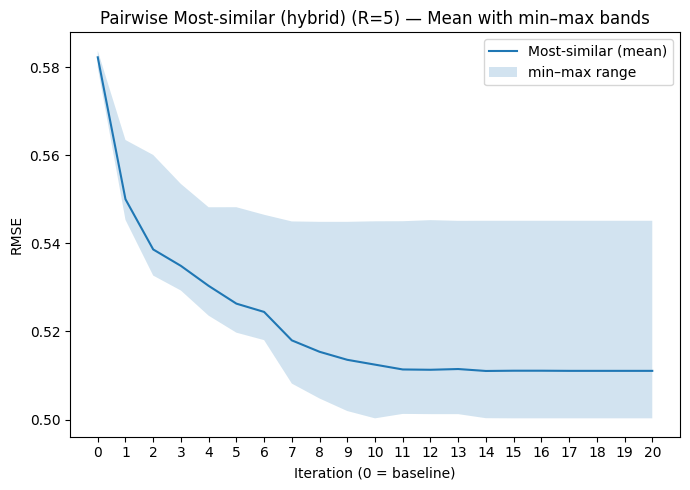

In [12]:
seeds = [101,102,103,104,105]  # R=5
T = 20                           # run iterations per time


# curves_s1 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=1, mode="hybrid")
curves_s2 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=2, mode="hybrid")
# curves_s3 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=3, mode="hybrid")


#plot_mean_with_range_single(curves_s1, title="Pairwise Top-2 (hybrid)", label="Top-2")
plot_mean_with_range_single(curves_s2, title="Pairwise Most-similar (hybrid)", label="Most-similar")
# plot_mean_with_range_single(curves_s3, title="Pairwise Least-similar (hybrid)", label="Least-similar")
